# Import modules

In [1]:
from IPython.display import clear_output

import os
import collections
import glob
import ssl
import multiprocessing as mp
import sys
from pathlib import Path

import time
import copy
import numbers
import math

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset

from torchvision import datasets, transforms, models
from torchvision.datasets.utils import download_url, extract_archive
from torchvision.utils import make_grid


# Download dataset

In [2]:
def download_dataset(url='https://sid.erda.dk/share_redirect/heaAFNnmaG/data.zip',
                     zip_name='beetles.zip', folder_name='beetles',
                     force_download=False, root='./data/'):
    ssl._create_default_https_context = ssl._create_unverified_context
    archive = os.path.join(root, zip_name)
    data_folder = os.path.join(root, folder_name)
    if (not os.path.exists(data_folder) or force_download):
        download_url(url, root, zip_name)
        extract_archive(archive, data_folder, False)
    return data_folder

data_folder = download_dataset()
image_folder = data_folder+'/images/'

# Import dataset

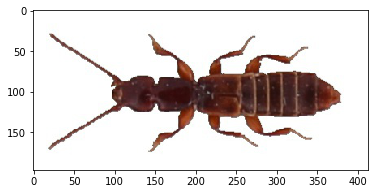

In [3]:
dataset = datasets.ImageFolder(image_folder)
image, label = dataset[0]
plt.imshow(image)

# Set up device and workers

In [4]:
# start by setting up device
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of threads to handle data. bug makes ipynb hang when num > 0 on windows.
if sys.platform == "linux" or device == 'cpu':
    num_workers = mp.cpu_count()
else:
    num_workers = 0

# Split dataset into train, validation and test sets

In [5]:
def split_dataset(dataset, train_ratio, val_ratio):

    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * (len(dataset) - train_size))
    test_size = len(dataset) - (train_size + val_size)
    dataset_sizes = {'train': train_size, 'val': val_size, 'test': test_size}
    train_data, val_data, test_data = random_split(
        dataset, dataset_sizes.values())
    return train_data, val_data, test_data, dataset_sizes

train_data, val_data, test_data, dataset_sizes = split_dataset(dataset, 0.8, 0.5)
print(str(dataset_sizes))

{'train': 11118, 'val': 1390, 'test': 1390}


# Apply augmentations

## Utility class allowed transformations on different data subsets

In [6]:
class TransformsDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

## Apply basic rescaling and tensorfication

In [7]:
img_height = 224
img_width = 448
resize = transforms.Resize((img_height, img_width))
tensorfy = transforms.ToTensor()
transforms_pre_norm = transforms.Compose([resize, tensorfy])
train_data_pre_norm = TransformsDataset(train_data, transforms_pre_norm)

## Get train set mean and std

In [8]:
def dataset_stats(data_set, load=True, num_workers=mp.cpu_count(),
                  path='models/beetle_mean_std.npy', batch_size=32):

    if load:
        mean, std = np.load(path)

    else:
        loader = torch.utils.data.DataLoader(
            data_set,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False
        )
        cnt = 0
        fst_moment = torch.empty(3)
        snd_moment = torch.empty(3)

        for data, _ in loader:

            b, c, h, w = data.shape
            nb_pixels = b * h * w
            sum_ = torch.sum(data, dim=[0, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
            fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
            snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

            cnt += nb_pixels
        mean = fst_moment.cpu().detach().numpy()
        std = torch.sqrt(snd_moment - fst_moment ** 2).cpu().detach().numpy()
        Path("models").mkdir(parents=True, exist_ok=True)
        np.save(path, np.stack((mean, std)))
    return mean, std

mean, std = dataset_stats(train_data_pre_norm)

print(mean, std)


[0.8442649  0.82529384 0.82333773] [0.28980458 0.32252666 0.3240354 ]


## Apply transformation with normalization

In [9]:
normalize = transforms.Normalize(mean, std)
transforms_norm = transforms.Compose([transforms_pre_norm, normalize])
train_data_norm = TransformsDataset(train_data_pre_norm, normalize)
val_data_norm = TransformsDataset(val_data, transforms_norm)
test_data_norm = TransformsDataset(test_data, transforms_norm)

# Initialize data-loaders

In [10]:
# larger batch size induces faster convergence (usually) but be wary, your GPU might run out of memory. 
# Also smaller sizes induces learning which generalize better.
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_data_norm, batch_size=batch_size,
                                            num_workers=num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data_norm, batch_size=batch_size,
                                        num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data_norm, batch_size=batch_size,
                                        num_workers=num_workers)
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# Define helper functions for showing tensors and plotting metrics

In [11]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def show_tensor(inp, mean=IMAGENET_MEAN, std=IMAGENET_STD,
           title=None, save_path=None, dpi=200, close=False,
           figsize=(7, 7), show_axis = 'on'):

    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    plt.axis(show_axis)
    if title is not None:
        plt.title(title)
    if save_path is not None:
        Path("figures").mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight',
                    dpi=dpi, facecolor='w')
    if close:
        plt.close()
    plt.pause(0.001)  # pause a bit so that plots are updated


In [12]:
def multiplot(systems, x_axis, y_axis, labels, name=None,
              title=None, dpi=200):
    plt.figure()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    for i in range(len(systems)):
        plt.plot(systems[i, 0], systems[i, 1], label=labels[i])
        plt.title(title, pad=20)
    plt.legend()
    plt.grid()
    if name is not None:
        Path("figures").mkdir(parents=True, exist_ok=True)
        plt.savefig('figures/'+name,  bbox_inches='tight',
                    facecolor='w', dpi=dpi)
    plt.show()
    plt.close()

# Illustrate train loader batch

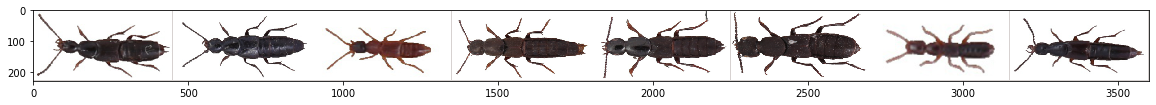

In [13]:
iterable = iter(train_loader)
images, labels = next(iterable)
img_grid = make_grid(images, nrow = 8)
show_tensor(img_grid, mean, std, figsize=(20, 20))


# Define the classification model

In [14]:
model = models.resnet50(pretrained=True)
num_fc = model.fc.in_features

# were just counting the number of classes by counting subfolders in image folder
num_classes = len(next(os.walk(image_folder))[1])
model.fc = nn.Linear(num_fc, num_classes)
# used for later
model = model.to(device)

# Define the loss function and optimizer

In [15]:
# what kind of objective will we be using for our classification?
# we are dealing with multiclass classification so cross entropy loss makes sense
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized (i.e. all layers are unfrozen)
optimizer = optim.Adam(model.parameters(), lr = 0.001, eps = 0.1)

# experiment 1: use SGD instead
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# experiment 2: use weight decay
# Decay LR by a factor of 0.1 every 7 epochs (experiment with this)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model

## Early stopping utility class

In [16]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """

    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(
                f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

## main trainer function

In [17]:
def fit(model, data_loaders, dataset_sizes, criterion, 
                optimizer, early_stopping, scheduler = None,
                num_epochs=100, device="cuda:0", plot = True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    epochs = []

    for epoch in np.arange(num_epochs) + 1:
        epochs.append(epoch)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double()).item() / dataset_sizes[phase]
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping(epoch_loss)
        clear_output(wait=True)
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'Train', train_loss[-1], train_acc[-1]))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'Val', val_loss[-1], val_acc[-1]))
        print()
        if plot == True:
            current_accs = np.array([train_acc[:epoch], val_acc[:epoch]])
            systems = np.array([[epochs, current_acc] for current_acc in current_accs])
            plot_labels = ['Training', 'Validation']
            multiplot(systems, 'Epoch', 'Accuracy', plot_labels)
        if early_stopping.early_stop:
            break       
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    metrics = np.array([epochs, train_loss, train_acc, 
                        val_loss, val_acc]).T
    return metrics

## Utility function for plotting training metrics

In [18]:
def plot_metrics(metrics, name='model_0'):
    epochs = metrics[:, 0]
    remaining_metrics = metrics[:, 1:]
    systems = np.array([[epochs, metric] for metric in remaining_metrics.T])
    labels = ['Training', 'Validation']
    multiplot(systems[[0, 2]], 'Epoch', 'Loss',
              labels, name + '_loss_comparison.pdf')
    multiplot(systems[[1, 3]], 'Epoch', 'Accuracy',
              labels, name + '_accuracy_comparison.pdf')

## Model evaluator

In [19]:
def test_model(model, test_loaders, device="cuda:0"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loaders:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100 * correct / total)
    print('Accuracy of the network on test images: %.2f %%' %
          (accuracy))
    return accuracy

## Utility functions for loading and saving a model

In [20]:
def load_model(model, name, optim=False, get_dataloaders=False, 
                get_train_metrics=False, get_test_scores = False,
               device="cuda:0"):
    output = []
    path = 'models/' + name
    model.load_state_dict(torch.load(
        path + '_parameters.pt', map_location=device))
    if optim:
        optim.load_state_dict(torch.load(
            path + '_optim.pt', map_location=device))
    if get_dataloaders:
        data_loaders = torch.load(
            path + '_dataloaders.pt', map_location=device)
        output.append(data_loaders)
    if get_train_metrics:
        metrics = np.load(path + '_train_metrics.npy')
        output.append(metrics)
    if get_test_scores:
        test_scores = np.load(path + '_test_scores.npy')
        output.append(test_scores)
    return output

In [21]:
def save_model(model, name='model_0', optim=None,
               dataloaders=None, train_metrics=None, 
               test_scores = None):
    Path("models").mkdir(parents=True, exist_ok=True)
    path = 'models/' + name
    torch.save(model.state_dict(), path + '_parameters.pt')
    if optim is not None:
        torch.save(optim.state_dict(), path + '_optim.pt')
    if dataloaders is not None:
        torch.torch.save(dataloaders, path + '_dataloaders.pt')
    if train_metrics is not None:
        np.save(path + '_train_metrics.npy', train_metrics)
    if test_scores is not None:
        np.save(path + '_test_scores.npy', test_scores)

## Now load and or train transfer-learned resnet50 model

In [22]:
load = False
train = False
if load == True:
    [metrics, [acc]] = load_model(model, name = 'model_0_full', 
        get_test_scores = True,get_train_metrics = True, device = device)
    print(("test accuracy = %.2f %%" % (acc) ))
if train == True:
    metrics = fit(model, data_loaders, dataset_sizes, criterion,
                  optimizer,  EarlyStopping(patience=5), device=device)
    acc = test_model(model, data_loaders['test'])
    save_model(model, name = 'model_0_full', train_metrics = metrics, 
                test_scores = np.array([acc]))
_ = model.eval()
#plot_metrics(metrics)

# Expose layers in Resnet

In [23]:
class Dreamnet50(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = copy.deepcopy(model)
        self.layers = {}
        for param in self.model.parameters():
            param.requires_grad = False
        for (name, layer) in self.model.named_children():
            if isinstance(layer, nn.Sequential):
                for (i, sub_layer) in enumerate(layer):
                    self.layers[(name + '_'+str(i))] = sub_layer
            else:
                self.layers[name] = layer     

    def forward(self, x, out_info):
        out_activations = {}
        for (name, layer) in self.layers.items():
            if name == 'fc':
                x = x.view(x.size(0), -1)
            x = layer(x)
            for (out_name, out_idxs) in out_info:
                if name == out_name:
                    if out_idxs == None:
                        out_activations[name] = x
                    else:
                        out_activations[name + '_' + str(out_idxs)] = x[:,out_idxs]
        return out_activations

In [24]:
dreamnet = Dreamnet50(model)
dreamnet.eval()
print(dreamnet.layers.keys())

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1_0', 'layer1_1', 'layer1_2', 'layer2_0', 'layer2_1', 'layer2_2', 'layer2_3', 'layer3_0', 'layer3_1', 'layer3_2', 'layer3_3', 'layer3_4', 'layer3_5', 'layer4_0', 'layer4_1', 'layer4_2', 'avgpool', 'fc'])


# Deepdream

## Define adapters for tensors

In [25]:
def input_adapter(img, device='cuda:0'):
    tensor = transforms.ToTensor()(img).to(device).unsqueeze(0)
    tensor.requires_grad = True
    return tensor

def output_adapter(tensor):
    return tensor.to('cpu').detach().squeeze(0)

## Create image scale space level

In [26]:
def scale_level(img, start_size, level, ratio=1.8,
                levels=4, device='cuda:0'):
    exponent = level - levels + 1
    h, w = np.round(np.float32(start_size) * (ratio ** exponent)).astype(np.int32)
    scaled_img = cv.resize(img, (w, h))
    scaled_tensor = input_adapter(scaled_img, device)
    return scaled_tensor

## Random shift utility function

In [27]:
def random_shift(tensor, h_shift, w_shift, undo=False):
    if undo:
        h_shift = -h_shift
        w_shift = -w_shift
    with torch.no_grad():
        rolled = torch.roll(tensor, shifts=(h_shift, w_shift), dims=(2, 3))
        rolled.requires_grad = True
        return rolled

## Channel-wise image gradient smoothing using 3 x 3 gaussian kernels

In [28]:
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """

    def __init__(self, kernel_size, sigma, device = 'cuda:0'):
        super().__init__()

        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size, kernel_size]

        # std multipliers, hardcoded to use 3 different Gaussian kernels
        cascade_coefficients = [0.5, 1.0, 2.0]
        sigmas = [[coeff * sigma, coeff * sigma]
                  for coeff in cascade_coefficients]  # isotropic Gaussian

        # assure we have the same spatial resolution
        self.pad = int(kernel_size[0] / 2)

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid(
            [torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * \
                    torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)
            kernel = kernel.to(device)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad,
                      self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

## Main loop of deepdream

In [29]:
def dreamspace(img, model, config):
    output_tensors = []

    if isinstance(config['target_shape'], int):
        current_height, current_width = img.shape[:2]
        new_height = int(current_height *
                         (config['target_shape'] / current_width))
        img = cv.resize(img, (config['target_shape'], new_height), 
                        interpolation=cv.INTER_CUBIC)

    elif isinstance(config['target_shape'], collections.abc.Sequence):
        img = cv.resize(img, (config['target_shape'][1], config['target_shape'][0]),
                        interpolation=cv.INTER_CUBIC)

    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range

    if config['use_noise'] == 'uniform':
        (h, w) = config['noise_shape']
        img = np.random.uniform(size=(h, w, 3)).astype(np.float32)
    elif config['use_noise'] == 'gaussian':
        (h, w) = config['noise_shape']
        img = np.random.normal(size=(h, w, 3)).astype(np.float32)

    img = (img - config['mean']) / config['std']
    start_size = img.shape[:-1]  # save initial height and width

    for level in range(config['levels']):
        scaled_tensor= scale_level(img, start_size, level,
                                    config['ratio'], config['levels'],  config['device'])
        for i in range(config['num_iters']):
            if config['shift'] == True:
                h_shift, w_shift = np.random.randint(
                    -config['shift_size'], config['shift_size'] + 1, 2)
                scaled_tensor = random_shift(scaled_tensor, h_shift, w_shift)
            dreamt_tensor = dream_ascent(scaled_tensor, model, i, config)
            if config['shift'] == True:
                dreamt_tensor = random_shift(dreamt_tensor, h_shift,
                                             w_shift, undo=True)
            if config['show'] == True:
                clear_output(wait=True)
                show_tensor(output_adapter(dreamt_tensor), config['mean'], 
                        config['std'], figsize=config['figsize'], show_axis = 'off')
            if (i % config['save_interval']) == 0:
                output_tensors.append(dreamt_tensor)

            scaled_tensor = dreamt_tensor
        tensor = output_adapter(dreamt_tensor)
        img = tensor.numpy().transpose((1, 2, 0))
        
    if config['img_path'] is not None:
        clear_output(wait=True)
        show_tensor(output_adapter(output_tensors[-1]), 
                config['mean'], config['std'],
                save_path=config['img_path'], dpi=config['dpi'], 
               figsize=config['figsize'], show_axis = 'off')
    if config['video_path'] is not None:
        Path('videos/temp/').mkdir(parents=True, exist_ok=True)
        with imageio.get_writer(config['video_path'], mode='I') as writer:
            for i, tensor in enumerate(output_tensors):
                clear_output(wait=True)
                show_tensor(output_adapter(tensor), config['mean'], config['std'],
                       save_path='videos/temp/'+str(i) + '.jpg', 
                       dpi=200, close=True, figsize=config['figsize'], show_axis = 'off')
                image = imageio.imread('videos/temp/'+str(i) + '.jpg')
                writer.append_data(image)
                os.remove('videos/temp/'+str(i) + '.jpg')
        writer.close()
    return output_tensors

## Perform one iteration of gradient ascent

In [30]:
def dream_ascent(tensor, model, iter, config):
    ## get activations
    activations = model(tensor, config['out_info'])
    ### calculate loss on desired layers
    losses = []
    for layer_activation in activations.values():
        if config['loss_type'] == 'norm':
            loss = torch.linalg.norm(layer_activation)
        elif config['loss_type'] == 'mean_red':
            loss = torch.mean(layer_activation)
        else:
            MSE = torch.nn.MSELoss(reduction='mean')
            zeros = torch.zeros_like(layer_activation)
            loss = MSE(layer_activation, zeros)
        losses.append(loss)
    if config['loss_red'] == 'mean':
        loss = torch.mean(torch.stack(losses))
    else:
        loss = torch.sum(torch.stack(losses))
    # do backpropagation and get gradient
    loss.backward()
    grad = tensor.grad.data
    ### gaussian smoothing
    if config['smooth'] == True:
        sigma = ((iter + 1) / config['num_iters']
                 ) * 2.0 + config['smooth_coef']
        smooth_grad = CascadeGaussianSmoothing(
            kernel_size=config['kernel_size'], sigma=sigma, 
            device=config['device'])(grad)
    else:
        smooth_grad = grad
    ### normalization of gradient
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    smooth_grad = smooth_grad - g_mean
    smooth_grad = smooth_grad / g_std
    ### gradient update ####
    tensor.data += config['lr'] * smooth_grad
    tensor.grad.data.zero_()
    ### clamp gradient to avoid it diverging. vanishing/exploding gradient phenomenon?
    if config['clamp_type'] == 'norm':
        image_min = torch.tensor(
            (-config['mean'] / config['std']).reshape(1, -1, 1, 1)).to(config['device'])
        image_max = torch.tensor(
            ((1 - config['mean']) / config['std']).reshape(1, -1, 1, 1)).to(config['device'])
    else:
        image_min, image_max = -1, 1
    tensor.data = torch.clip(tensor, image_min, image_max)
    return tensor

# set default parameters

In [31]:
DREAM_CONFIG = {
    'ratio': 1.8,
    'levels': 4,
    'num_iters': 10,
    'target_shape': 600,
    'lr': 0.09,
    'out_info': [('fc', None)],
    'shift': True,
    'shift_size': 32,
    'loss_type': 'norm',
    'loss_red': 'mean',
    'eps': 10e-8,
    'clamp_type': 'norm',
    'smooth': True,
    'kernel_size': 9,
    'smooth_coef': 0.5,
    'mean': IMAGENET_MEAN,
    'std': IMAGENET_STD,
    'show': True,
    'use_noise': None,
    'noise_shape': (224, 448),
    'figsize': (15, 15),
    'device': 'cuda:0',
    'save_interval': 5,
    'img_path': None,
    'dpi': 200,
    'video_path': None}

# Lets dream!

## Choose image

In [32]:
species_name = 'achenium_humile'
image_name = '_0189_0'
image_path = image_folder + species_name + '/' + image_name + '.jpg'
print(image_path)
input_image = cv.imread(image_path)[:, :, ::-1]

./data/beetles/images/achenium_humile/_0189_0.jpg


## Choose parameters and apply method

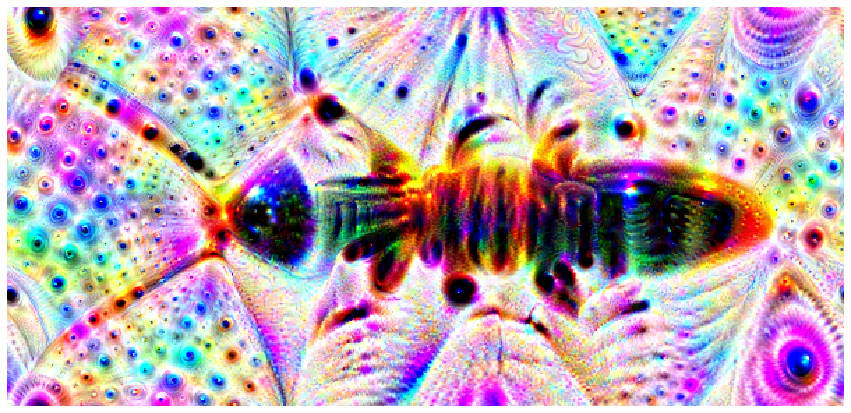

In [33]:
params = {
    'mean': mean,
    'std': std,
    'out_info': [('layer3_5', None)],
    'num_iters': 30,
    #'lr': 0.1,
    #'smooth_coef': 0,
    'device': device,
    #'use_noise': 'gaussian'
}
save_path = species_name + image_name
config = copy.deepcopy(DREAM_CONFIG)
for (name, param) in params.items():
    save_path += ('_' + name + '_' + str(param))
    config[name] = param

img_path = 'figures/' + save_path + '.jpg'
video_path = 'videos/' + save_path + '.gif'
config['img_path'] = img_path
config['video_path'] = video_path

dream_tensors = dreamspace(input_image, dreamnet, config)
